<a href="https://colab.research.google.com/github/hyejeong1111/Object-size-measurement-project/blob/main/U_net%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alexklibisz/isbi-2012.git

Cloning into 'isbi-2012'...
remote: Enumerating objects: 278, done.
remote: Total 278 (delta 0), reused 0 (delta 0), pack-reused 278
Receiving objects: 100% (278/278), 1.31 GiB | 28.18 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Updating files: 100% (24/24), done.


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
dir_data = '/content/isbi-2012/data'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

In [4]:
img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))


In [5]:
ny, nx = img_label.size
nframe = img_label.n_frames

In [6]:
nframe_train = 24
nframe_val = 3
nframe_test = 3


In [7]:
dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

In [8]:
if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

In [9]:
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

In [10]:
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)


In [11]:
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)


In [12]:
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

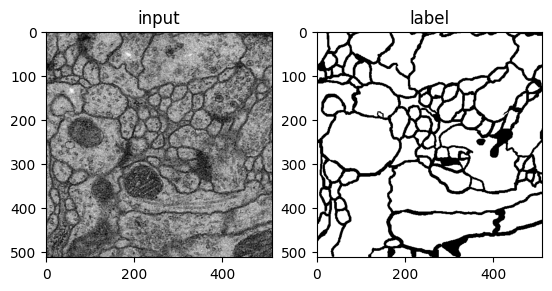

In [13]:
plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

In [14]:
print(len(dir_save_train), len(dir_save_val))

29 27


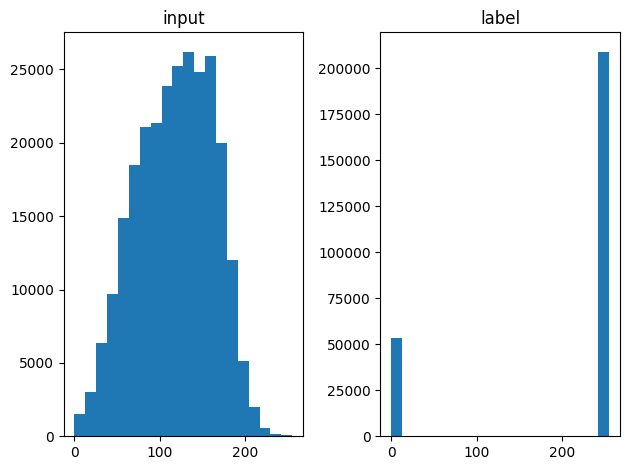

In [15]:
plt.subplot(122)
plt.hist(label_.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input_.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

In [16]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # 정규화
        label = label/255.0
        input = input/255.0

        # 이미지와 레이블의 차원 = 2일 경우(채널이 없을 경우, 흑백 이미지), 새로운 채널(축) 생성
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        # transform이 정의되어 있다면 transform을 거친 데이터를 불러옴
        if self.transform:
            data = self.transform(data)

        return data

In [25]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 논문의 파란색 화살표
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            # Conv2d layer 정의
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        # 좌측 레이어 enc (인코더)
        # 1층 좌측 첫번째 레이어 두개
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)

        # 다음 빨간색 화살표 max_pool 2*2
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # 2층 파란색 화살표
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)

        # 다음 빨간색 화살표 max_pool 2*2
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # 3층 파란색 화살표
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)

        # 다음 빨간색 화살표 max_pool 2*2
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # 4층 파란색 화살표
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)

        # 다음 빨간색 화살표 max_pool 2*2
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        # 5층 파란색 화살표
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=True)

        # Expansive path
        # 5층 파란색 2번째 화살표인데 디코더로
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)

        # 초록색 화살표
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        # enc4_2와 대칭이 되는 점을 보면 dec4_2 input 값은 512가 맞는데, unet 아키텍처를 보니
        # enc4_2에서 회색 화살표로 dec4_2로 와서 copy and crop이 일어남
        # 따라서 dec4_2 in_channels = 1024로 설정
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)

        # 초록색 화살표
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        # 3층 파란색 화살표
        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        # 초록색 화살표
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        # 2층 파란색 화살표
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        # 초록색 화살표
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        # 1층 파란색 화살표
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        # segmentation에 필요한 n개의 클래스에 대한 output 정의
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):

        # 좌측 1층 레이어 2개 연결 및 빨간색 화살표
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        # 좌측 2층 레이어 2개 연결 및 빨간색 화살표
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        # 좌측 3층 레이어 2개 연결 및 빨간색 화살표
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        # 좌측 4층 레이어 2개 연결 및 빨간색 화살표
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        # 좌측 5층 레이어
        enc5_1 = self.enc5_1(pool4)

        # 우측 5층 레이어 및 초록색 화살표
        dec5_1 = self.dec5_1(enc5_1)
        unpool4 = self.unpool4(dec5_1)

        # 하얀색 부분 연결하기
        cat4 = torch.cat((unpool4, enc4_2), dim=1)

        # 파란색 화살표 실행
        # cat에서 512 + 512 로 1024의 레이어 만들고 파란색 화살표 수행후 아웃풋값을 512로 만듬
        dec4_2 = self.dec4_2(cat4)

        # 여기까지 하면 우측 4층 레이어까지 생성
        dec4_1 = self.dec4_1(dec4_2)

        # 반복 3층
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        # 반복 2층
        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        # 반복 1층
        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

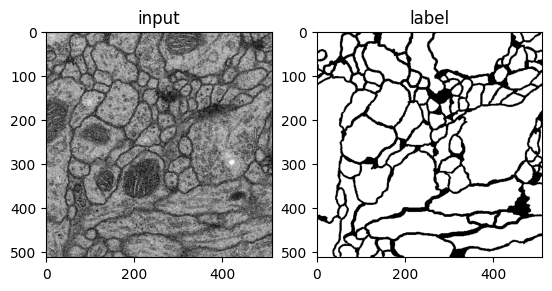

In [19]:
dataset_train = Dataset(data_dir=dir_save_train)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.imshow(label.reshape(512,512), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(512,512), cmap='gray')
plt.title('input')

plt.show()

In [20]:
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

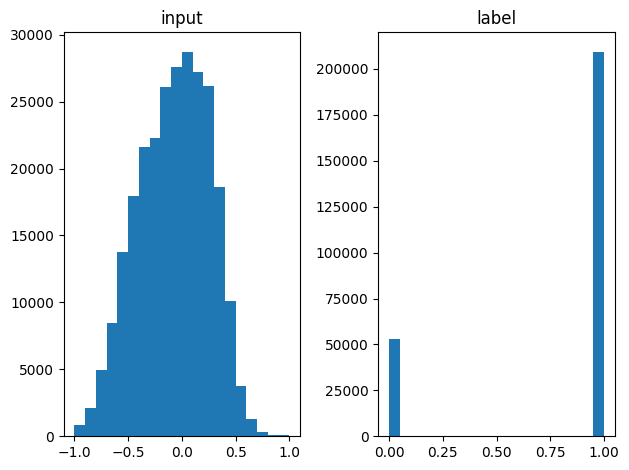

In [21]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

In [22]:
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch


In [26]:
import os
from torch.utils.tensorboard import SummaryWriter

lr = 1e-3
batch_size = 4
num_epoch = 20

base_dir = '/content/isbi-2012'
data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")


# 훈련을 위한 Transform과 DataLoader
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

# 손실함수 정의하기
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                # Tensorboard 저장하기
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch 50마다 모델 저장하기
        if epoch % 50 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

        writer_train.close()
        writer_val.close()

TRAIN: EPOCH 0001 / 0020 | BATCH 0001 / 0006 | LOSS 0.6439
TRAIN: EPOCH 0001 / 0020 | BATCH 0002 / 0006 | LOSS 0.5721
TRAIN: EPOCH 0001 / 0020 | BATCH 0003 / 0006 | LOSS 0.5423
TRAIN: EPOCH 0001 / 0020 | BATCH 0004 / 0006 | LOSS 0.5219
TRAIN: EPOCH 0001 / 0020 | BATCH 0005 / 0006 | LOSS 0.5011
TRAIN: EPOCH 0001 / 0020 | BATCH 0006 / 0006 | LOSS 0.4886
VALID: EPOCH 0001 / 0020 | BATCH 0001 / 0001 | LOSS 0.6120
TRAIN: EPOCH 0002 / 0020 | BATCH 0001 / 0006 | LOSS 0.3848
TRAIN: EPOCH 0002 / 0020 | BATCH 0002 / 0006 | LOSS 0.3907
TRAIN: EPOCH 0002 / 0020 | BATCH 0003 / 0006 | LOSS 0.3784
TRAIN: EPOCH 0002 / 0020 | BATCH 0004 / 0006 | LOSS 0.3738
TRAIN: EPOCH 0002 / 0020 | BATCH 0005 / 0006 | LOSS 0.3681
TRAIN: EPOCH 0002 / 0020 | BATCH 0006 / 0006 | LOSS 0.3654
VALID: EPOCH 0002 / 0020 | BATCH 0001 / 0001 | LOSS 0.5255
TRAIN: EPOCH 0003 / 0020 | BATCH 0001 / 0006 | LOSS 0.3230
TRAIN: EPOCH 0003 / 0020 | BATCH 0002 / 0006 | LOSS 0.3264
TRAIN: EPOCH 0003 / 0020 | BATCH 0003 / 0006 | LOSS 0.32

In [27]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j

              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

TEST: BATCH 0001 / 0001 | LOSS 0.2210
AVERAGE TEST: BATCH 0001 / 0001 | LOSS 0.2210


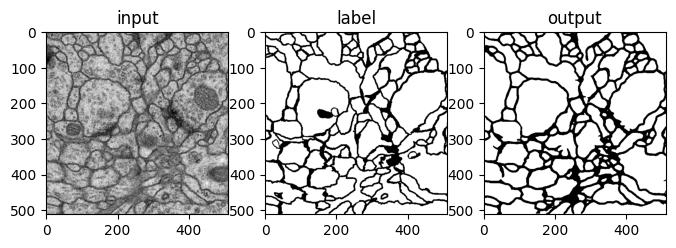

In [28]:
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()
